In [1]:
import numpy as np
from TMDP import TMDP
from model_functions import *
from policy_utils import *
import matplotlib.pyplot as plt
import gymnasium as gym
from algorithms import *
from FrozenLake import *
import pandas as pd
import constants
#np.set_printoptions(precision=4)
import math
from policy_utils import *
import torch
import mlflow
from CurriculumPMPO import CurriculumPMPO
import optuna
from experiment_result_utils import *
nrows = 20
nS = nrows**2
nA = 4
seed = constants.SEEDS[0]
set_policy_seed(seed)
num_bins = 10
gamma = .999
tau = 0.6
dense_reward = True
shape_range=(-1,0)
goal_reward = 1.
#tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
#mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
env = FrozenLakeEnv(is_slippery=False, seed=seed, 
                        desc=generate_random_map(nrows, seed=seed), 
                        reward_shape=True,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
xi = np.ones(env.nS) * 1/env.nS
tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)

Current seed for result reproducibility: 2999


In [2]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]
V = compute_V_from_Q(Q, get_policy(Q))
j_opt = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)

optimal performance:  -19.18138293061904


In [3]:
"""env.render_mode = "human"
env.render()"""

'env.render_mode = "human"\nenv.render()'

In [4]:
model_lr = 0.373715
pol_lr = 0.215723
temp = 36.039501
epochs = 3
entropy_coef = 0.400000
eps_shift = 2e-3
batch_size = 20
debug = False

In [5]:
episodes = 1900000
final_temp=1
lam = 1
param_decay=True
eps_ppo = 0.2

In [6]:
curr_PMPO = CurriculumPMPO(tmdp, checkpoint_step=500)
tmdp.update_tau(tau) # Reset the teleport rate        

In [7]:
curr_PMPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_shift=eps_shift,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef, debug=debug)

Episode: 5000 reward: -1237.4999999999998 length: 22 tau 0.6
Episode: 10000 reward: -837.5000000000002 length: 57 tau 0.6
Episode: 15000 reward: -390.4999999999999 length: 77 tau 0.6
Episode: 20000 reward: -1140.2 length: 56 tau 0.6
Episode: 25000 reward: -955.9 length: 130 tau 0.6
Episode: 30000 reward: -649.4 length: 35 tau 0.6
Episode: 35000 reward: -1326.3999999999996 length: 11 tau 0.6
Episode: 40000 reward: -1638.7999999999997 length: 62 tau 0.6
Episode: 45000 reward: -1684.6000000000001 length: 0 tau 0.6
Episode: 50000 reward: -1062.2 length: 32 tau 0.6
Episode: 55000 reward: -1277.4 length: 73 tau 0.6
Episode: 60000 reward: -1204.9999999999995 length: 140 tau 0.6
Episode: 65000 reward: -389.3 length: 72 tau 0.6
Episode: 70000 reward: -1327.0 length: 47 tau 0.6
Episode: 75000 reward: -1098.5999999999992 length: 96 tau 0.6
Episode: 80000 reward: -1230.2999999999995 length: 40 tau 0.6
Episode: 85000 reward: -1070.4 length: 4 tau 0.6
Episode: 90000 reward: -1103.3 length: 24 tau 0.

In [8]:
#V_Q = compute_V_from_Q(Q, get_policy(curr_PMPO.Q))
V_curr = compute_V_from_Q(Q, get_softmax_policy(curr_PMPO.theta, temperature=1e-4))

j_curr = compute_expected_j(V_curr, tmdp.env.mu)
#j_q_curr = compute_expected_j(V_Q, tmdp.env.mu)
j_opt = compute_expected_j(V, tmdp.env.mu)

print("optimal performance: ",j_opt)
print("curriculum performance: ", j_curr)
#print("Q curriculum performance: ",j_q_curr)


optimal performance:  -19.18138293061904
curriculum performance:  -19.18138293061904


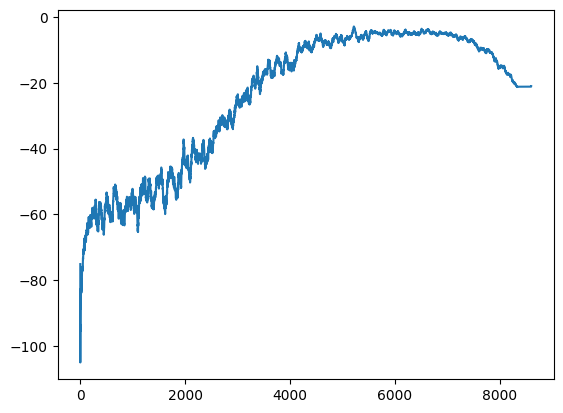

In [9]:
import matplotlib.pyplot as plt
rewards = curr_PMPO.reward_records
# Generate recent 50 interval average
avg_rewards = []
for idx in range(len(rewards)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = rewards[:idx+1]
    else:
        avg_list = rewards[idx-49:idx+1]
    avg_rewards.append(np.average(avg_list)/batch_size)
# Plot
#plt.plot(rewards)
plt.plot(avg_rewards)

In [10]:
pi = get_policy(get_softmax_policy(curr_PMPO.theta, temperature=1e-4))
#pi = get_policy(Q)

In [11]:
print(curr_PMPO.theta[0])
print(pi[0])

[   0.36595476 -117.09199235  122.53514303   -5.80910544]
[0. 0. 1. 0.]


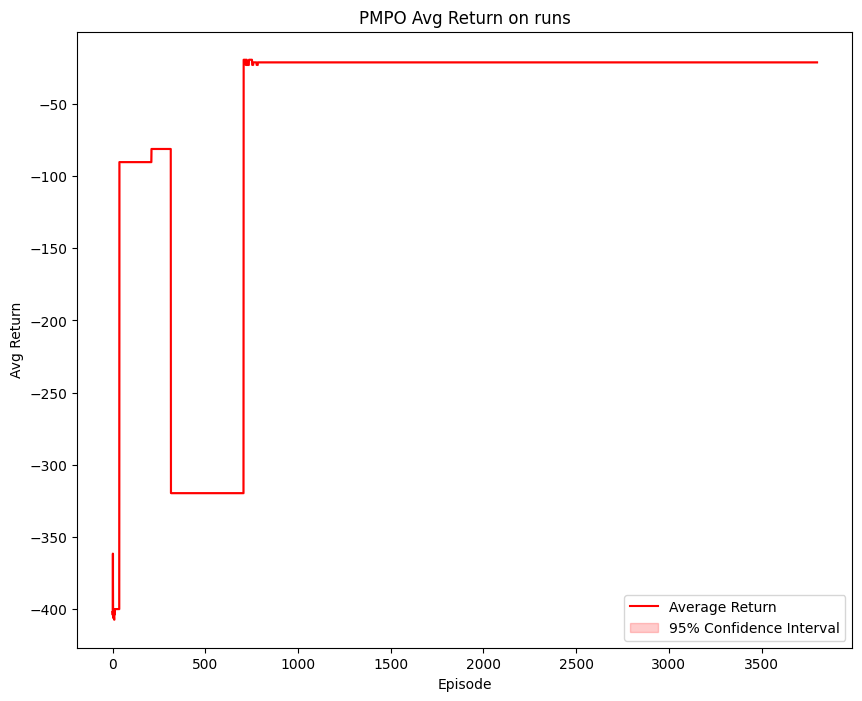

In [12]:

test_rewards = test_policies(tmdp, curr_PMPO.thetas, 100, 1e-5)
rewards_fig = plot_avg_test_return([test_rewards], f"PMPO Avg Return on runs")


In [13]:

tmdp.update_tau(0.)
tmdp.reset()
done = False
step = 0
env.render_mode = "human"
while True:
    s = tmdp.env.s
    a = select_action(pi[s])
    s_prime, reward, flags, prob = tmdp.step(a)
    print("state {} action {} next state {} reward {}".format(s, a, s_prime, reward))
    if flags["done"]:
        tmdp.reset()
        break
    step +=1
    if step > min(100,nrows*3):
        break


state 0 action 2 next state 1 reward -1.0
state 1 action 2 next state 2 reward -1.0
state 2 action 1 next state 22 reward -1.0
state 22 action 1 next state 42 reward -0.9
state 42 action 1 next state 62 reward -0.9
state 62 action 0 next state 61 reward -0.9
state 61 action 1 next state 81 reward -0.9
state 81 action 1 next state 101 reward -0.9
state 101 action 1 next state 121 reward -0.9
state 121 action 2 next state 122 reward -0.8
state 122 action 2 next state 123 reward -0.8
state 123 action 2 next state 124 reward -0.8
state 124 action 2 next state 125 reward -0.8
state 125 action 1 next state 145 reward -0.7
state 145 action 2 next state 146 reward -0.7
state 146 action 2 next state 147 reward -0.7
state 147 action 1 next state 167 reward -0.7
state 167 action 1 next state 187 reward -0.6
state 187 action 1 next state 207 reward -0.6
state 207 action 2 next state 208 reward -0.6
state 208 action 1 next state 228 reward -0.6
state 228 action 2 next state 229 reward -0.5
state 22